### Data Modelling for crime-house price prediction

In [3]:
## load dataset

import pandas as pd
# import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import datetime
from scipy import stats
import seaborn as sns

crimes_2012 = pd.read_csv('Chicago_Crimes_2012_to_2017.csv', sep=',', error_bad_lines=False)
crimes_2012.drop_duplicates(subset=['ID', 'Case Number', 'Date'], inplace=True)
crimes_2012.drop(['Unnamed: 0','Case Number','IUCR','FBI Code','Updated On',
                  'X Coordinate','Y Coordinate'], inplace = True, axis = 1)
crimes_2012 = crimes_2012.dropna(axis = 0, how = 'any')

## date conversion
crimes_2012.Date = pd.to_datetime(crimes_2012.Date, format = '%m/%d/%Y %I:%M:%S %p')
# crimes_2012.index = pd.DatetimeIndex(crimes_2012.Date)
crimes_2012['Primary Type'] = pd.Categorical(crimes_2012['Primary Type'])
crimes_2012['Description'] = pd.Categorical(crimes_2012['Description'])
crimes_2012['Location Description'] = pd.Categorical(crimes_2012['Location Description'])

In [4]:
import re
crimes_2012['Primary Type']=crimes_2012['Primary Type'].apply(lambda x: re.sub(' ', '_', str(x)).lower())
crimes_2012.head(3)

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Year,Latitude,Longitude,Location
0,10508693,2016-05-03 23:40:00,013XX S SAWYER AVE,battery,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1022,10.0,24.0,29.0,2016,41.864073,-87.706819,"(41.864073157, -87.706818608)"
1,10508695,2016-05-03 21:40:00,061XX S DREXEL AVE,battery,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,313,3.0,20.0,42.0,2016,41.782922,-87.604363,"(41.782921527, -87.60436317)"
2,10508697,2016-05-03 23:31:00,053XX W CHICAGO AVE,public_peace_violation,RECKLESS CONDUCT,STREET,False,False,1524,15.0,37.0,25.0,2016,41.894908,-87.758372,"(41.894908283, -87.758371958)"


In [5]:
### community area name
area_names = """
01	Rogers Park	
40	Washington Park
02	West Ridge	
41	Hyde Park
03	Uptown	
42	Woodlawn
04	Lincoln Square	
43	South Shore
05	North Center	
44	Chatham
06	Lakeview	
45	Avalon Park
07	Lincoln Park	
46	South Chicago
08	Near North Side	
47	Burnside
09	Edison Park	
48	Calumet Heights
10	Norwood Park	
49	Roseland
11	Jefferson Park	
50	Pullman
12	Forest Glen	
51	South Deering
13	North Park	
52	East Side
14	Albany Park	
53	West Pullman
15	Portage Park	
54	Riverdale
16	Irving Park	
55	Hegewisch
17	Dunning	
56	Garfield Ridge
18	Montclare	
57	Archer Heights
19	Belmont Cragin	
58	Brighton Park
20	Hermosa	
59	McKinley Park
21	Avondale	
60	Bridgeport
22	Logan Square	
61	New City
23	Humboldt Park	
62	West Elsdon
24	West Town	
63	Gage Park
25	Austin	
64	Clearing
26	West Garfield Park 	
65	West Lawn
27	East Garfield Park	
66	Chicago Lawn
28	Near West Side	
67	West Englewood
29	North Lawndale	
68	Englewood
30	South Lawndale	
69	Greater Grand Crossing
31	Lower West Side	
70	Ashburn
32	Loop	
71	Auburn Gresham	
33	Near South Side	
72	Beverly
34	Armour Square	
73	Washington Heights
35	Douglas	
74	Mount Greenwood
36	Oakland	
75	Morgan Park
37	Fuller Park	
76	O'Hare
38	Grand Boulevard	
77	Edgewater
39	Kenwood	
"""

In [6]:
## neighborhood : community name
neighborhood_Map = """
Cabrini–Green	Near North Side	
The Gold Coast	Near North Side	
Goose Island	Near North Side	
Magnificent Mile	Near North Side	
Old Town	Near North Side	
River North	Near North Side	
River West	Near North Side	
Streeterville	Near North Side	
Loop	Loop	
Near East Side	Loop	
South Loop	Loop	
West Loop Gate	Loop	
Dearborn Park	Near South Side	
Printer's Row	Near South Side	
South Loop	Near South Side	
Prairie Avenue Historic District	Near South Side	
Horner Park	North Center	
Roscoe Village	North Center	
Boystown	Lake View	
Lake View East	Lake View	
Graceland West	Lake View	
South East Ravenswood	Lake View	
Wrigleyville	Lake View	
Old Town Triangle	Lincoln Park	
Park West	Lincoln Park	
Ranch Triangle	Lincoln Park	
Sheffield Neighbors	Lincoln Park	
Wrightwood Neighbors	Lincoln Park	
Belmont Gardens	Avondale	
Chicago's Polish Village	Avondale	
Kosciuszko Park	Avondale	
Belmont Gardens	Logan Square	
Bucktown	Logan Square	
Kosciuszko Park	Logan Square	
Palmer Square	Logan Square	
East Rogers Park	Rogers Park	
Arcadia Terrace	West Ridge	
Peterson Park	West Ridge	
West Rogers Park	West Ridge	
Buena Park	Uptown	
Argyle Street	Uptown	
Margate Park	Uptown	
Sheridan Park	Uptown	
Ravenswood	Lincoln Square	
Ravenswood Gardens	Lincoln Square	
Rockwell Crossing	Lincoln Square	
Edison Park	Edison Park	
Big Oaks	Norwood Park	
Old Norwood Park	Norwood Park	
Oriole Park	Norwood Park	
Union Ridge	Norwood Park	
Gladstone Park	Jefferson Park	
Edgebrook	Forest Glen	
Old Edgebrook	Forest Glen	
South Edgebrook	Forest Glen	
Sauganash	Forest Glen	
Wildwood	Forest Glen	
Brynford Park	North Park	
Hollywood Park	North Park	
River's Edge	North Park	
Sauganash Woods	North Park	
Mayfair	Albany Park	
North Mayfair	Albany Park	
Ravenswood Manor	Albany Park	
Schorsch Forest View	O'Hare	
Andersonville	Edgewater	
Edgewater Beach	Edgewater	
Magnolia Glen	Edgewater	
Lakewood/Balmoral	Edgewater	
Belmont Central	Portage Park	
Władysławowo	Portage Park	
Six Corners	Portage Park	
Avondale Gardens	Irving Park	
Independence Park	Irving Park	
Kilbourn Park	Irving Park	
Little Cassubia	Irving Park	
Old Irving Park	Irving Park	
West Walker	Irving Park	
The Villa	Irving Park	
Belmont Heights	Dunning	
Belmont Terrace	Dunning	
Irving Woods	Dunning	
Schorsch Village	Dunning	
Montclare	Montclare	
Belmont Central	Belmont Cragin	
Hanson Park	Belmont Cragin	
Belmont Gardens	Hermosa	
Kelvyn Park	Hermosa	
East Village	West Town	
Noble Square	West Town	
Polish Downtown	West Town	
Pulaski Park	West Town	
Smith Park	West Town	
Ukrainian Village	West Town	
Wicker Park	West Town	
Galewood	Austin	
The Island	Austin	
West Garfield Park	West Garfield Park	
Fifth City	East Garfield Park	
Greektown	Near West Side	
Little Italy	Near West Side	
Tri-Taylor	Near West Side	
Lawndale	North Lawndale	
Homan Square	North Lawndale	
Douglas Park	North Lawndale	
Little Village	South Lawndale	
Heart of Chicago	Lower West Side	
Heart of Italy	Lower West Side	
Pilsen	Lower West Side	
East Pilsen	Lower West Side	
Chinatown	Armour Square	
Wentworth Gardens	Armour Square	
Bridgeport, Chicago	Armour Square	
Groveland Park	Douglas	
Lake Meadows	Douglas	
the Gap	Douglas	
Prairie Shores	Douglas	
South Commons	Douglas	
Oakland	Oakland	
Fuller Park	Fuller Park	
Bronzeville	Grand Boulevard	
Kenwood	Kenwood	
South Kenwood	Kenwood	
Washington Park	Washington Park	
East Hyde Park	Hyde Park	
Hyde Park	Hyde Park	
West Woodlawn	Woodlawn	
Jackson Park Highlands	South Shore	
Bridgeport	Bridgeport	
Grand Crossing	Greater Grand Crossing	
Parkway Gardens	Greater Grand Crossing	
Park Manor	Greater Grand Crossing	
LeClaire Courts	Garfield Ridge	
Sleepy Hollow	Garfield Ridge	
Vittum Park	Garfield Ridge	
Archer Heights	Archer Heights	
Brighton Park	Brighton Park	
McKinley Park 	McKinley Park	
Back of the Yards	New City	
Canaryville	New City	
West Elsdon	West Elsdon	
Gage Park	Gage Park	
Chrysler Village	Clearing	
Ford City	West Lawn	
West Lawn	West Lawn	
Lithuanian Plaza	Chicago Lawn	
Marquette Park	Chicago Lawn	
West Englewood	West Englewood	
Englewood	Englewood	
East Chatham	Chatham	
West Chatham	Chatham	
West Chesterfield	Chatham	
Avalon Park	Avalon Park	
Marynook	Avalon Park	
Stony Island Park	Avalon Park	
The Bush	South Chicago	
Burnside	Burnside	
Pill Hill	Calumet Heights	
Fernwood	Roseland	
Rosemoor	Roseland	
Cottage Grove Heights	Pullman	
London Towne	Pullman	
Jeffrey Manor	South Deering	
Trumbull Park	South Deering	
Altgeld Gardens	Riverdale	
Eden Green	Riverdale	
Golden Gate	Riverdale	
East Side	East Side	
West Pullman	West Pullman	
Hegewisch	Hegewisch	
Beverly View	Ashburn	
Mary Crest	Ashburn	
Parkview	Ashburn	
Scottsdale	Ashburn	
Wrightwood	Ashburn	
Auburn Gresham	Auburn Gresham	
Beverly	Beverly	
Brainerd	Washington Heights	
Longwood Manor	Washington Heights	
Princeton Park	Washington Heights	
Mount Greenwood Heights	Mount Greenwood	
Talley's Corner	Mount Greenwood	
Beverly Woods	Morgan Park	
Kennedy Park	Morgan Park	
West Morgan Park	Morgan Park	
"""

In [7]:
code_pairs = [[float(p[0]), p[1]] for p in [pair.strip().split('\t') for pair in area_names.strip().split('\n')]]
area_name_dic = {float(k[0]):k[1] for k in code_pairs} # code -> community area
area_toCode_dic = {k[1] : float(k[0]) for k in code_pairs} # community area -> code

code_pairs_neighborhoods = [[p[0], p[1]] for p in [pair.strip().split('\t') for pair in neighborhood_Map.strip().split('\n')]]
neighborhood_name_dic = {k[0]:k[1] for k in code_pairs_neighborhoods} #neighborhood -> community area

In [8]:
df =  crimes_2012.drop(['Latitude', 'Longitude', 'Location', 'ID','Date'], axis=1)
df.columns = [str(re.sub(' ', '_', str(x))).lower() for x in df.columns]
df['community_name'] = df['community_area'].map(area_name_dic)
df['neighbordhood'] = df['community_name'].map(neighborhood_name_dic)
df.dropna()
df.head(4)

,block,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,year,community_name,neighbordhood
0,013XX S SAWYER AVE,battery,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1022,10.0,24.0,29.0,2016,North Lawndale,NaN
1,061XX S DREXEL AVE,battery,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,313,3.0,20.0,42.0,2016,Woodlawn,NaN
2,053XX W CHICAGO AVE,public_peace_violation,RECKLESS CONDUCT,STREET,False,False,1524,15.0,37.0,25.0,2016,Austin,NaN
3,049XX W FULTON ST,battery,SIMPLE,SIDEWALK,False,False,1532,15.0,28.0,25.0,2016,Austin,NaN


### real eastate and geomap data

In [9]:
house_df = pd.read_excel('real_eastate_data_main.xlsx')
house_df.columns=house_df.columns.astype(str)
# house_df.columns=house_df.columns.astype(str)
house_df=house_df.set_index('Region')
house_df.columns=pd.to_datetime(house_df.columns)
house_ann= house_df.T.groupby(house_df.columns.year).agg('mean').T
# house_ann.reset_index(inplace=True)
house_ann.reset_index(inplace=True)
house_ann =  house_ann.rename(columns={2012: 'Avg_Price_2012', 2013: 'Avg_Price_2013', 
                                       2014: 'Avg_Price_2014', 2015: 'Avg_Price_2015',
                                      2016: 'Avg_Price_2016', 2017: 'Avg_Price_2017', 
                                       2018: 'Avg_Price_2018', 2019: 'Avg_Price_2019'})

house_ann.head(4)

# df.reset_index(inplace=True) 
# house_ann =house_df.T.groupby(house_df.columns.year).agg(['mean','median']).T.unstack()
# house_ann.columns = house_ann.columns.map('{0[0]}{0[1]}'.format)
# s.columns=s.columns.map('_'.join)
# s.columns = s.columns.map('{0[0]}{0[1]}'.format)

,Region,Avg_Price_2012,Avg_Price_2013,Avg_Price_2014,Avg_Price_2015,Avg_Price_2016,Avg_Price_2017,Avg_Price_2018,Avg_Price_2019
0,"Chicago, IL metro area",100.454545,108.383333,117.558333,123.616667,130.658333,137.991667,142.316667,137.15
1,"Chicago, IL",125.400000,143.016667,161.600000,172.333333,183.283333,189.691667,192.891667,177.85
2,"Chicago, IL - Albany Park",91.727273,114.033333,134.991667,159.850000,165.791667,175.666667,178.425000,182.50
3,"Chicago, IL - Andersonville",186.100000,204.116667,217.925000,229.183333,248.016667,246.391667,253.733333,241.15


In [10]:
regions = []
for r in house_df.index:
    if '-' in r:
        index = r.find('-')
        new_reg = r[index+2:]
        regions.append(new_reg)
    else:
        regions.append(r)

In [11]:
house_ann['Area_Name'] = regions
house_ann.head(5)

,Region,Avg_Price_2012,Avg_Price_2013,Avg_Price_2014,Avg_Price_2015,Avg_Price_2016,Avg_Price_2017,Avg_Price_2018,Avg_Price_2019,Area_Name
0,"Chicago, IL metro area",100.454545,108.383333,117.558333,123.616667,130.658333,137.991667,142.316667,137.15,"Chicago, IL metro area"
1,"Chicago, IL",125.400000,143.016667,161.600000,172.333333,183.283333,189.691667,192.891667,177.85,"Chicago, IL"
2,"Chicago, IL - Albany Park",91.727273,114.033333,134.991667,159.850000,165.791667,175.666667,178.425000,182.50,Albany Park
3,"Chicago, IL - Andersonville",186.100000,204.116667,217.925000,229.183333,248.016667,246.391667,253.733333,241.15,Andersonville
4,"Chicago, IL - Arcadia Terrace",75.490909,115.900000,138.283333,123.700000,148.900000,142.650000,168.691667,160.75,Arcadia Terrace


In [12]:
code = []
for row in house_ann.itertuples(index=True,name='Pandas'):
    #convert neighborhoods to community areas
    comm_area = None
    if row.Area_Name in neighborhood_name_dic.keys():
        comm_area = neighborhood_name_dic[row.Area_Name]
    else:
        comm_area = row.Area_Name
    
    if comm_area in area_toCode_dic.keys():
        code.append(area_toCode_dic[comm_area])
    else:
        code.append(None)

In [13]:
house_ann['community_area'] = code
# house_ann.drop('Region', 1)
# house_ann.dropna().drop('Region', 1)
house_ann.head()

,Region,Avg_Price_2012,Avg_Price_2013,Avg_Price_2014,Avg_Price_2015,Avg_Price_2016,Avg_Price_2017,Avg_Price_2018,Avg_Price_2019,Area_Name,community_area
0,"Chicago, IL metro area",100.454545,108.383333,117.558333,123.616667,130.658333,137.991667,142.316667,137.15,"Chicago, IL metro area",NaN
1,"Chicago, IL",125.400000,143.016667,161.600000,172.333333,183.283333,189.691667,192.891667,177.85,"Chicago, IL",NaN
2,"Chicago, IL - Albany Park",91.727273,114.033333,134.991667,159.850000,165.791667,175.666667,178.425000,182.50,Albany Park,14.0
3,"Chicago, IL - Andersonville",186.100000,204.116667,217.925000,229.183333,248.016667,246.391667,253.733333,241.15,Andersonville,77.0
4,"Chicago, IL - Arcadia Terrace",75.490909,115.900000,138.283333,123.700000,148.900000,142.650000,168.691667,160.75,Arcadia Terrace,2.0


In [14]:
crime_catg = df.groupby(['community_name','primary_type'])['primary_type'].count().unstack()
crime_catg = crime_catg[['theft','battery', 'criminal_damage', 'narcotics', 'assault', 'other_offense',
                        'burglary', 'deceptive_practice', 'motor_vehicle_theft', 'robbery']]
crime_catg = crime_catg.dropna()
crime_catg.columns = crime_catg.columns.add_categories(['community_name'])
crime_catg.columns = pd.Index(list(crime_catg.columns))
crime_catg.reset_index(inplace=True)
crime_catg.head(5)
# crime_catg.rename(columns=str).reset_index()
house_ann.head()

,Region,Avg_Price_2012,Avg_Price_2013,Avg_Price_2014,Avg_Price_2015,Avg_Price_2016,Avg_Price_2017,Avg_Price_2018,Avg_Price_2019,Area_Name,community_area
0,"Chicago, IL metro area",100.454545,108.383333,117.558333,123.616667,130.658333,137.991667,142.316667,137.15,"Chicago, IL metro area",NaN
1,"Chicago, IL",125.400000,143.016667,161.600000,172.333333,183.283333,189.691667,192.891667,177.85,"Chicago, IL",NaN
2,"Chicago, IL - Albany Park",91.727273,114.033333,134.991667,159.850000,165.791667,175.666667,178.425000,182.50,Albany Park,14.0
3,"Chicago, IL - Andersonville",186.100000,204.116667,217.925000,229.183333,248.016667,246.391667,253.733333,241.15,Andersonville,77.0
4,"Chicago, IL - Arcadia Terrace",75.490909,115.900000,138.283333,123.700000,148.900000,142.650000,168.691667,160.75,Arcadia Terrace,2.0


In [15]:
### join crime data with real estate data
final_df = pd.merge(crime_catg, house_ann, left_on='community_name', right_on='Area_Name')
final_df.drop(['Area_Name', 'community_area', 'Region'], axis=1, inplace=True)
final_df.head()

,community_name,theft,battery,criminal_damage,narcotics,assault,other_offense,burglary,deceptive_practice,motor_vehicle_theft,robbery,Avg_Price_2012,Avg_Price_2013,Avg_Price_2014,Avg_Price_2015,Avg_Price_2016,Avg_Price_2017,Avg_Price_2018,Avg_Price_2019
0,Albany Park,2782.0,2417.0,1825.0,666.0,736.0,758.0,841.0,465.0,792.0,564.0,91.727273,114.033333,134.991667,159.850000,165.791667,175.666667,178.425000,182.50
1,Archer Heights,1295.0,746.0,809.0,250.0,277.0,265.0,410.0,215.0,415.0,218.0,91.954545,111.183333,112.866667,117.991667,119.541667,128.791667,146.058333,156.50
2,Ashburn,2769.0,1932.0,1864.0,608.0,880.0,934.0,1156.0,683.0,794.0,542.0,86.954545,92.608333,102.333333,112.333333,121.966667,133.483333,145.916667,140.35
3,Auburn Gresham,6467.0,8895.0,4455.0,4008.0,3051.0,2617.0,2630.0,1437.0,1527.0,2012.0,32.454545,30.900000,34.066667,40.391667,49.375000,52.025000,61.025000,57.20
4,Austin,13376.0,18996.0,8051.0,18228.0,5834.0,5769.0,3372.0,2732.0,3529.0,4070.0,33.781818,42.591667,51.466667,56.958333,63.708333,78.608333,93.916667,103.60


### get annual crime count for each crime type for each region

In [16]:
crimes_2012['Date'] = pd.to_datetime(crimes_2012['Date'], format='%m/%d/%Y %H:%M:%S %p')
top_occured_crimes = ['theft','battery', 'criminal_damage', 'narcotics', 'assault', 'other_offense',
                        'burglary', 'deceptive_practice', 'motor_vehicle_theft', 'robbery']
df = crimes_2012[crimes_2012['Primary Type'].isin(top_occured_crimes)]
df_cross = (pd.crosstab(index=df['Community Area'],
                        columns=[df['Date'].dt.year, df['Primary Type']]).sort_index(axis=1, level=[1, 0]))
df_cross.columns = ['{}_{}'.format(crime, year) for year, crime in df_cross.columns]
df_cross.reset_index(inplace=True)
df_cross['community_name'] = df['Community Area'].map(area_name_dic)
df_cross.drop('Community Area', axis=1, inplace=True)
df_cross.dropna()
df_cross.head(4)

,assault_2012,assault_2013,assault_2014,assault_2015,assault_2016,battery_2012,battery_2013,battery_2014,battery_2015,battery_2016,...,robbery_2013,robbery_2014,robbery_2015,robbery_2016,theft_2012,theft_2013,theft_2014,theft_2015,theft_2016,community_name
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,North Lawndale
1,340,303,257,234,227,991,866,776,666,724,...,136,113,106,154,1043,1004,811,845,851,Woodlawn
2,254,225,201,166,198,658,669,574,544,534,...,151,110,90,122,976,991,794,669,694,NaN
3,244,277,210,233,241,736,667,593,661,653,...,122,102,113,139,1338,1134,952,879,968,Austin


In [20]:
crime_finalDF = pd.merge(df_cross, house_ann, left_on='community_name', right_on='Area_Name')
crime_finalDF.dropna()
crime_finalDF.drop(['Region', 'community_name'], 1, inplace=True)
crime_finalDF.tail(6)

# crime_finalDF.to_csv('crime_realEstate', sep='\t', encoding='utf-8')

,assault_2012,assault_2013,assault_2014,assault_2015,assault_2016,battery_2012,battery_2013,battery_2014,battery_2015,battery_2016,...,Avg_Price_2012,Avg_Price_2013,Avg_Price_2014,Avg_Price_2015,Avg_Price_2016,Avg_Price_2017,Avg_Price_2018,Avg_Price_2019,Area_Name,community_area
52,493,418,377,372,422,1412,1235,1112,1048,1065,...,12.154545,11.058333,17.550000,16.583333,26.625000,26.675000,37.541667,43.05,West Garfield Park,26.0
53,654,593,582,507,567,2228,2004,1719,1662,1571,...,36.936364,37.758333,46.733333,53.833333,65.225000,70.391667,76.633333,90.70,Avalon Park,45.0
54,579,538,509,546,545,1873,1715,1478,1603,1572,...,131.745455,148.900000,161.591667,169.525000,181.450000,189.158333,198.366667,195.45,Jefferson Park,11.0
55,263,268,222,255,211,733,660,555,602,567,...,19.472727,21.525000,28.441667,30.825000,31.416667,44.616667,50.025000,45.10,Greater Grand Crossing,69.0
56,48,37,52,61,25,107,96,88,87,103,...,84.490909,92.583333,113.583333,113.141667,167.766667,188.458333,210.583333,211.10,Lower West Side,31.0
57,166,189,140,170,147,433,428,368,345,379,...,153.690909,168.083333,180.841667,182.191667,199.158333,203.958333,213.233333,200.00,Uptown,3.0


### linear regression model

In [22]:
## Experiment: just try it with combined features by year
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import re

cols_2012 = crime_finalDF.filter(regex='_2012').columns
crime_finalDF['Area_Name']=crime_finalDF['Area_Name'].apply(lambda x: re.sub(' ', '_', str(x)))
regDF_2012 = crime_finalDF[cols_2012]
regDF_2012 = regDF_2012.assign(community_code=crime_finalDF['community_area'])
regDF_2012.dropna(inplace=True)

X_feats = regDF_2012.drop(['Avg_Price_2012'], axis=1)
y_label = regDF_2012['Avg_Price_2012'].values


# # # sc_x = StandardScaler()
# # # y= sc_y.fit_transform(y_label)

poly = PolynomialFeatures(degree=2)
sc_y = StandardScaler()
X = poly.fit_transform(X_feats)
y= sc_y.fit_transform(y_label.reshape(-1,1)).flatten()
regModel = LinearRegression()
regModel.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [26]:
# regModel.intercept_
# regModel.coef_

In [33]:
### let's try with multivariate regression model
import statsmodels.api as sm

X_feats = regDF_2012.drop(['Avg_Price_2012'], axis=1)
y_label = regDF_2012['Avg_Price_2012'].values

X_= sm.add_constant(X_feats)
estimator = sm.OLS(y_label, X_).fit()
estimator.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     3.804
Date:                Thu, 25 Apr 2019   Prob (F-statistic):           0.000645
Time:                        12:33:07   Log-Likelihood:                -321.11
No. Observations:                  58   AIC:                             666.2
Df Residuals:                      46   BIC:                             691.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      174.7050     26.321      6.637      0.000     121.724     227.686
assault_2012                 0.0470      0.292      0.161      0.873      -0.541       0.635
battery_2012                -0.0983      0.114     -0.865      0.391      -0.327       0.130
burglary_2012               -0.0290      0.143     -0.202      0.841      -0.317       0.259
criminal_damage_2012         0.1836      0.196      0.934      0.355      -0.212       0.579
deceptive_practice_2012      0.0075      0.155      0.048      0.962      -0.305       0.320
motor_vehicle_theft_2012     0.0222      0.154      0.144      0.886      -0.287       0.332
narcotics_2012               0.0209      0.042      0.503      0.617      -0.063       0.105
other_offense_2012          -0.0728      0.206     -0.354      0.725      -0.487       0.341
robbery_2012                 0.0732      0.227      0.322      0.749      -0.384       0.530
theft_2012                  -0.0201      0.034     -0.589      0.559      -0.089       0.049
community_code              -2.5051      0.454     -5.515      0.000      -3.419      -1.591
==============================================================================
Omnibus:                        2.969   Durbin-Watson:                   0.952
Prob(Omnibus):                  0.227   Jarque-Bera (JB):                2.736
Skew:                           0.454   Prob(JB):                        0.255
Kurtosis:                       2.446   Cond. No.                     5.50e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [80]:
## try this

### Feature selection with cross validation
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LinearRegression
import numpy as np

seed=np.random.seed(234)

X_train, X_test, y_train, y_test = train_test_split(X_feats, y_label, test_size = 0.2, random_state = seed)
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=seed)

## try with linear regression
estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=cv, scoring = 'r2')
linReg = selector.fit(X_train, y_train)
linReg.score(X_test, y_test)

0.30207341514152986

In [82]:
### try with ensemble tree
from sklearn import ensemble
ensemble_reg = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, min_samples_split = 2, learning_rate = 0.1, loss = 'ls')
ens_reg = ensemble_reg.fit(X_train, y_train)
ens_reg.score(X_test, y_test)

0.664267893007112

In [129]:
### try with PCA
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np

pca = PCA()
pca_ = pca.fit_transform(scale(regDF_2012))

np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

n = len(pca_)
kf_10 = KFold(n, n_folds=10, shuffle=True, random_state=0)
# kf_10 = KFold(n, shuffle=True, random_state=2)
regr = LinearRegression()
mse = []

score = -1*cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_10, scoring='mean_squared_error').mean()    
mse.append(score) 

for i in np.arange(1,6):
    score = -1*cross_val_score(regr, X_reduced[:,:i], y.ravel(), cv=kf_10, scoring='mean_squared_error').mean()
    mse.append(score)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(mse, '-v')
ax2.plot([1,2,3,4,5], mse[1:6], '-v')
ax2.set_title('Intercept excluded from plot')

for ax in fig.axes:
    ax.set_xlabel('Number of principal components in regression')
    ax.set_ylabel('MSE')
    ax.set_xlim((-0.2,5.2))

C:\Users\jshayi2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  if __name__ == '__main__':


TypeError: __init__() got an unexpected keyword argument 'n_folds'

In [89]:
# pca.explained_variance_ratio_
# pca.components_

In [97]:
## rendering plot for selected features

In [101]:
# def get_pca_plot(score,coeff,labels=None):
#     xs = score[:,0]
#     ys = score[:,1]
#     n = coeff.shape[0]

#     plt.scatter(xs ,ys, c = y) #without scaling
#     for i in range(n):
#         plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
#         if labels is None:
#             plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
#         else:
#             plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

# plt.xlabel("PC{}".format(1))
# plt.ylabel("PC{}".format(2))
# plt.grid()

# #Call the function. 
# get_pca_plot(x_new[:,0:2], pca. components_) 
# plt.show()

In [102]:
# print("Training accuracy:", regModel.score(X_train,y_train))
# print("Testing accuracy:", regModel.score(X_test,y_test))

In [107]:
### PCA 

C:\Users\jshayi2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\jshayi2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


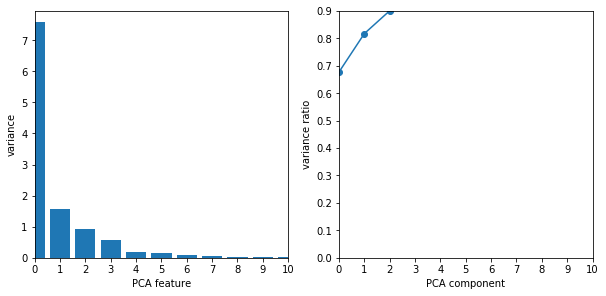

In [127]:
from sklearn.pipeline import make_pipeline

scaler = StandardScaler()
pca = PCA(n_components=11)
pipeline = make_pipeline(scaler,pca)
pipeline.fit(X_feats)

# Plot of the explained pca variances
plt.figure(figsize=(10,10))
plt.subplot(221)
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.xlim([0,10]);

# Plot of cumulative explained variance ratio 
expvar = pd.DataFrame({'features':features,'varexp':pca.explained_variance_ratio_})
plt.subplot(222)
cumulative = np.cumsum(pca.explained_variance_ratio_)
plt.plot(features,cumulative ,marker='o')
plt.xlabel('PCA component')
plt.ylabel('variance ratio')
plt.xticks(features)
plt.xlim([0,10]);
plt.ylim([0,0.9]);

In [122]:
# cols_ = regDF_2012.filter(regex='_2012').columns
# selectedDF = regDF_2012[cols_]
# selectedDF.head(4)


In [83]:
cols_2013 = crime_finalDF.filter(regex='_2013').columns
# crime_finalDF['area'].apply(lambda x: re.sub(' ', '_', str(x)))
regDF_2013 = crime_finalDF[cols_2013]
regDF_2013.dropna(inplace=True)


X_feats = regDF_2013.drop(['Avg_Price_2013'], axis=1)
y_label = regDF_2013['Avg_Price_2013'].values

poly = PolynomialFeatures(degree=2)
# sc_x = StandardScaler()
sc_y = StandardScaler()
X = poly.fit_transform(X_feats)
y= sc_y.fit_transform(y_label .reshape(-1,1)).flatten()
# y= sc_y.fit_transform(y_label)
regModel_13 = LinearRegression()
regModel_13.fit(X, y)

C:\Users\jshayi2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Optimal number of features : 1


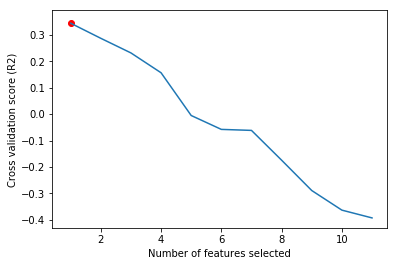

In [59]:
### Feature selection with cross validation
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LinearRegression
import numpy as np

seed=np.random.seed(234)

X_train, X_test, y_train, y_test = train_test_split(X_feats, y_label, test_size = 0.1, random_state = seed)

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=seed)

estimator = LinearRegression()
selector = RFECV(estimator, step=1, cv=cv, scoring = 'r2')
selector = selector.fit(X_train, y_train)


print("Optimal number of features : %d" % selector.n_features_)
mask = selector.get_support()

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (R2)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.scatter(selector.n_features_,np.max(selector.grid_scores_), c = 'red')
plt.show()

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

models = []
models.append(('LR', LinearRegression()))
models.append(('SVR', SVR()))
models.append(('DTR', DecisionTreeRegressor(random_state=seed)))
models.append(('RFR (15 Trees)', RandomForestRegressor(n_estimators=30, random_state=seed)))

In [61]:
def render_plot_selected_models(XX, yy):
    from sklearn.model_selection import ShuffleSplit
    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import make_scorer
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=seed)

    results = []
    names = []
    for name, model in models:
        cv_results = cross_val_score(model, XX, yy, cv = cv, scoring = make_scorer(r2_score))
        results.append(cv_results)
        names.append(name)
        msg = "%s: %.3f (+/- %.3f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

    fig = plt.figure()
    fig.suptitle('R2')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

LR: -0.231 (+/- 0.335)


C:\Users\jshayi2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jshayi2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\jshayi2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C

SVR: -0.264 (+/- 0.232)
DTR: 0.156 (+/- 0.954)
RFR (15 Trees): 0.555 (+/- 0.225)


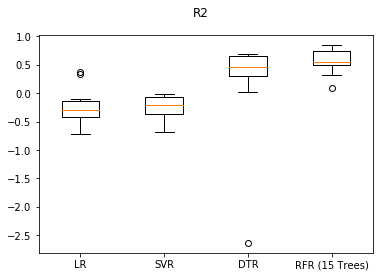

In [62]:
render_plot_selected_models(X_train, y_train)

In [ ]:
### Let's try it with LASSO
